In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from functools import reduce
from scipy.stats import linregress
from scipy import fftpack
from scipy.signal import detrend
from tqdm import tqdm
from scipy.optimize import root_scalar
from tqdm.notebook import tqdm_notebook
from scipy.optimize import curve_fit
from tsmoothie.smoother import LowessSmoother
import matplotlib
from statsmodels.tsa.stattools import acf, pacf
import mpl_interactions.ipyplot as iplt
from sklearn.metrics import r2_score
from scipy.stats import linregress
from scipy.signal import detrend
from collections import defaultdict
from sklearn.metrics import r2_score

In [48]:
'''
def psi(m, b):
    return (1/10) * b**(-1/10) * m**(-0.9)

def cumulativeM(m, b):
    return b**(-0.1) * m**(0.1)

def inverseCumM(u, b):
    return b * u**(10)
'''

def cumulative(b, delta, m):
    return b**(-delta) * m**(delta)

def inverseCum(b, delta, u):
    return b * u**(1/delta)

In [58]:
def pdfLogSpace(x, xb, gamma):
    return 2**(- gamma) * gamma * np.exp(gamma*(- x + xb + np.exp(xb) - 2*np.exp(x))+ np.log(1 + 2 * np.exp(x))) 


def cdfLogSpace(x, xb, gamma):
    return 1  - 2**(- gamma) * np.exp(gamma * (-2 * np.exp(x) + np.exp(xb) - x + xb))


def  drawCDF(unif, gamma, xb):
    #if np.sign(cdfLogSpace(-100, gamma = gamma, xb = xb) - unif) * np.sign(cdfLogSpace(50, gamma = gamma, xb = xb) - unif) == 1:
        #print(gamma, xb, unif, cdfLogSpace(-200, gamma = gamma, xb = xb) - unif, cdfLogSpace(50, gamma = gamma, xb = xb) - unif)
    return root_scalar(lambda t: cdfLogSpace(t, gamma = gamma, xb = xb) - unif, bracket=[-400, 20], method='brentq').root

In [50]:
criticalPoint = 1 / np.log(2)
gammaValues = - np.abs(np.logspace(np.log10(np.abs(1 - criticalPoint)), np.log10(1e-3), 100))  + criticalPoint
gamma_gammaC = np.abs(np.logspace(np.log10(np.abs(1 - criticalPoint)), np.log10(1e-3), 100))

In [51]:
def sizeAtBirth(gamma, xb0, seriesLength = 5000):
    uniformDraws = np.random.uniform(size = seriesLength)

    logSizes = np.zeros(seriesLength)
    logSizes[0] = xb0
    for i in range(1, seriesLength):
        logSizes[i] = drawCDF(unif = uniformDraws[i], gamma = gamma, xb = logSizes[i-1])

    return logSizes

In [52]:
def delta(distance):
    return 0.76*distance

#initalValues = {gammaValues[i]: delta(gamma_gammaC[i]) for i in range(len(gammaValues))}

In [53]:
nTrajectoires = 1

b = 10

pointsPerTrajectoiry = 1000000

#gammaValuesFiniteEffect = gammaValues[45:]

simulate = False
if simulate:
    startingPointsUniform = np.random.uniform(0, 1, len(gammaValues))
    startingPoints = [inverseCum(b = 10, delta = delta(gamma_gammaC[i]), u = startingPointsUniform[i]) for i in range(len(gammaValues))]
    aCorrValues = np.zeros((len(gammaValues), pointsPerTrajectoiry ))
    allSizes = np.zeros((len(gammaValues),  100000 ))#* nTrajectoires ))
    #for j, gamma in enumerate(tqdm_notebook(gammaValues[45:])):
    for j, gamma in enumerate(tqdm_notebook(gammaValues)):
        sizes = np.zeros(100000) #* nTrajectoires)
        #print(sizes.shape)
        #for i in range(nTrajectoires):
        
        #logSizes = sizeAtBirth(gamma = gamma, xb0 = np.log(startingPoints[10 * i + t]), seriesLength=pointsPerTrajectoiry)
        logSizes = sizeAtBirth(gamma = gamma, xb0 = np.log(startingPoints[j]), seriesLength=pointsPerTrajectoiry)
        #print((50 * i * 10) + 50*t,(50 * i * 10) + 50*(t + 1))
        sizes += logSizes[-100000:]#np.array([logSizes[l] for l in np.linspace(5000, 49999, 450).astype(int)]) 
        aCorr = acf(logSizes, fft = True, nlags = pointsPerTrajectoiry - 1)
        autocorrelation = acf(logSizes, fft = True, nlags = pointsPerTrajectoiry - 1)
        aCorrValues[j, :] += autocorrelation #]/ nTrajectoires 
        allSizes[j, :] = sizes

    # First save (Flattening effect)
    #np.save("../data/sizeAtBirthShort5000.npy", allSizes)
    #np.save("../data/aCorrValuesShortAverage.npy", aCorrValues)

    # Second save (Longer time series)
    #np.save("../../../data/sizeAtBirthShortSecondSave.npy", allSizes)
    #np.save("../../../data/aCorrValuesShortSecondSave.npy", aCorrValues)

    # Third save (1 very long time series)
    #np.save("../../../data/sizeAtBirthShort1Milion.npy", allSizes)
    #np.save("../../../data/aCorrValuesShort1Milion.npy", aCorrValues)

In [54]:
#allSizes = np.load("../../../data/sizeAtBirthShort5000.npy")
#aCorrValues = np.load("../../../data/aCorrValuesShortAverage.npy")

#allSizesSecondSave = np.load("../../../data/sizeAtBirthShortSecondSave.npy")
#aCorrValuesSecondSave = np.load("../../../data/aCorrValuesShortSecondSave.npy")

allSizes = np.load("../../../data/sizeAtBirthShort1Milion.npy")
aCorrValues = np.concatenate([np.load("../../../data/aCorrValuesShort1Milion.npy")[:84], np.load("../../../data/aCorrValuesShort1MilionSupplementary.npy")])

In [55]:
def powerLaw(x, a, b):
    return a*x**b

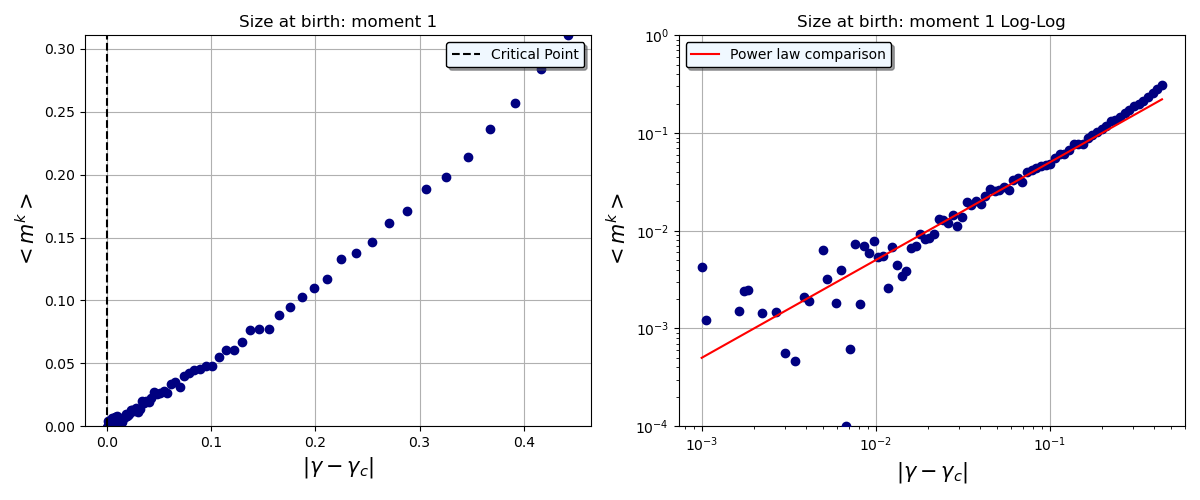

In [56]:
#omega2BelowCritical = omega2Values[omega2Values < criticalPoint]
%matplotlib ipympl
cmap = matplotlib.cm.get_cmap('Blues')
fig, ax1  = plt.subplots(1,2, figsize = (12, 5))
ax, ax_ = ax1.flatten()

#meanSizesAtBirth = np.load(f'../data/meanSizeBirth20000SingleTraitSamplingM.npy')

#####################################
# Put exp if working with logSizes  #
#####################################
def fY (x, k):
    title1 = f'Size at birth: moment {k}'
    ax.set_title(title1)
    yArr = allSizes**k
    
    y = np.mean(yArr, axis = 1)
    
    ax.set_ylim(bottom = np.min(y), top = np.max(y))
    return y



controls = iplt.scatter(gamma_gammaC, fY, k = [1, 2, 3, 4,5 , 6], color = 'navy', zorder = 2, ax = ax)



#ax.scatter(gammaValues  - criticalPoint, meanSizesAtBirth , color = 'navy', zorder = 2)

xAxis = np.linspace(np.min(gamma_gammaC), np.max(gamma_gammaC), 100)

#ax.plot(xAxis - criticalPoint, powerLaw(xAxis, *popt), label = f'Power law fit: $a = {popt[0]:.3}$, $b = {popt[1]:.3}$')
#ax.axvline(absorbingValue - criticalPoint, color = 'red', linestyle = '--', zorder = 2)
ax.axvline(0, color = 'black', linestyle = '--', label = 'Critical Point', zorder = 2)
ax.set_xlabel('$|\gamma - \gamma_c|$', fontsize = 15, zorder = 2)
ax.set_ylabel('$<m^k>$', fontsize = 15)
ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', loc = 'upper right')
#ax.set_title('Mean size at birth for different size of the system', fontsize = 15)
ax.grid(zorder = 1)
powerLawValues = {'1':(.5, 1), '2': (0.15, 1), '3': (0.1, 1) , '4':(0.08, 1), '5':(0.1, 1), '6':(0.1 , 1)}
def fY2 (x, k):
    title2 = f'Size at birth: moment {k} Log-Log'
    ax_.set_title(title2)
    yArr2 = allSizes**k
    y2 = np.mean(yArr2, axis = 1)
    #ax_.set_ylim(bottom = 0.9 * np.min(y2), top = 1.1*np.max(y2))
    return y2


def fY3 (x, k):
    y3 = powerLaw(xAxis,*powerLawValues[str(int(k))])
    return y3

#ax_.plot(xAxis, powerLaw(xAxis,*powerLawValues[str(int(k))]), color = 'red', label = f'm = {k} line', zorder = 4)
_ = iplt.scatter(gamma_gammaC, fY2, controls=controls, color = 'navy', ax = ax_, zorder = 3)

#_ = iplt.scatter(gamma_gammaC[45:], fYSecondSave, zorder = 3, ax = ax_, controls=controls, color = 'forestgreen')

_ = iplt.plot(xAxis, fY3, controls=controls, color = 'red', ax = ax_, zorder = 3, label = 'Power law comparison')


ax_.set_xscale('log')
ax_.set_yscale('log')
#ax_.scatter(gammaValues, sizeBirth20000.mean(axis = 1), zorder = 2, color = 'navy')
ax_.set_xlabel('$|\gamma - \gamma_c|$', fontsize = 15)
ax_.set_ylabel('$<m^k>$', fontsize = 15)
ax_.grid(zorder = 1)
#ax_.axvline(criticalPoint, color = 'black', linestyle = '--', label = 'Critical Point', zorder = 2)

#ax.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black')
#ax_.set_title('Mean size at birth for different generations, $log-log$')
ax_.legend(facecolor = 'aliceblue', shadow = True, edgecolor = 'black', loc = 'upper left')
ax_.set_ylim(bottom = 1e-4, top = 1)
fig.tight_layout()
plt.show()

In [11]:
############################################
# Version of the code dealing with logSizes#
############################################
'''
def slopeDistribution(x):
    counts, edges = np.histogram(x, bins = 'fd', density = True)
    binCenters = (edges[:-1] + edges[1:]) / 2
    maxCountsIdx = np.argmax(counts)
    filteredCenters = binCenters[:maxCountsIdx]
    filteredLogCounts = np.log10(counts)[:maxCountsIdx]
    slope, intercept, rValue, pValue, stderr = linregress(filteredCenters[~ np.isneginf(filteredLogCounts)], filteredLogCounts[~ np.isneginf(filteredLogCounts)])
    return slope, intercept, rValue, pValue, stderr


slopes = {distance : slopeDistribution(allSizes[gammaIdx, :])[0] for gammaIdx, distance in enumerate(gamma_gammaC)}
rValues = {distance : slopeDistribution(allSizes[gammaIdx, :])[2] for gammaIdx, distance in enumerate(gamma_gammaC)}
'''

################################################
# Version of the code not dealing with logSizes#
################################################

def slopeDistribution(x):
    counts, edges = np.histogram(x, bins = 1000, density = True)
    binCenters = (edges[:-1] + edges[1:]) / 2
    slope, intercept, rValue, pValue, stderr = linregress(binCenters[~ np.isneginf(np.log10(counts))], np.log10(counts)[~ np.isneginf(np.log10(counts))])
    return slope, intercept, rValue, pValue, stderr


slopes = {distance : slopeDistribution(allSizes[gammaIdx, :])[0] for gammaIdx, distance in enumerate(gamma_gammaC)}
rValues = {distance : slopeDistribution(allSizes[gammaIdx, :])[2] for gammaIdx, distance in enumerate(gamma_gammaC)}


/var/folders/92/pt64shtn3fx70tf0m4ng91240000gn/T/ipykernel_1206/3249761679.py:26: RuntimeWarning: divide by zero encountered in log10
  slope, intercept, rValue, pValue, stderr = linregress(binCenters[~ np.isneginf(np.log10(counts))], np.log10(counts)[~ np.isneginf(np.log10(counts))])
/Applications/anaconda3/envs/new_base/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Applications/anaconda3/envs/new_base/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Applications/anaconda3/envs/new_base/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [16]:
################################################
# Goodness of the fit plot                     #
################################################
'''
fig, ax = plt.subplots(1,1, figsize = (6, 5))
ax.scatter(rValues.keys(), rValues.values(), color = 'navy')
ax.set_xlabel('$|\gamma - \gamma_c|$', fontsize = 15)
ax.set_ylabel('Pearson\'s correlation coefficient', fontsize = 15)
ax.set_title('Goodness of the linear fit', fontsize = 18)
'''

"\nfig, ax = plt.subplots(1,1, figsize = (6, 5))\nax.scatter(rValues.keys(), rValues.values(), color = 'navy')\nax.set_xlabel('$|\\gamma - \\gamma_c|$', fontsize = 15)\nax.set_ylabel('Pearson's correlation coefficient', fontsize = 15)\nax.set_title('Goodness of the linear fit', fontsize = 18)\n"

In [17]:
################################################
# Delta as a function of the average size plot #
################################################


############################################
# Version of the code dealing with logSizes#
############################################
'''
fig, ax = plt.subplots(1,1, figsize = (6, 5))
ax.scatter(np.mean(np.exp(allSizes), axis = 1), slopes.values(), color = 'navy', zorder = 2)
ax.scatter(np.mean(np.exp(allSizesSecondSave), axis = 1), slopesSecondSave.values(), color = 'forestgreen', zorder = 1)
slope, intercept, rValue, pValue, stderr = linregress(np.mean(np.exp(allSizes), axis = 1), list(slopes.values()))
ax.set_title('$\delta$ as a function of $<m>$', fontsize = 18)
ax.set_xlabel('$<m>$')
ax.set_ylabel('$\delta$')
'''

################################################
# Version of the code not dealing with m       #
################################################

'''
fig, ax = plt.subplots(1,1, figsize = (6, 5))
ax.scatter(np.mean(allSizes, axis = 1), np.array(list(slopes.values())), color = 'navy', zorder = 2)
slope, intercept, rValue, pValue, stderr = linregress(np.mean(allSizes, axis = 1), np.array(list(slopes.values())) + 1)
ax.set_title('$\delta$ as a function of $<m>$', fontsize = 18)
ax.set_xlabel('$<m>$')
ax.set_ylabel('$\delta$')
ax.set_ylim(bottom = -2, top = 0)
'''

"\nfig, ax = plt.subplots(1,1, figsize = (6, 5))\nax.scatter(np.mean(allSizes, axis = 1), np.array(list(slopes.values())), color = 'navy', zorder = 2)\nslope, intercept, rValue, pValue, stderr = linregress(np.mean(allSizes, axis = 1), np.array(list(slopes.values())) + 1)\nax.set_title('$\\delta$ as a function of $<m>$', fontsize = 18)\nax.set_xlabel('$<m>$')\nax.set_ylabel('$\\delta$')\nax.set_ylim(bottom = -2, top = 0)\n"

In [14]:
############################################
# Version of the code dealing with logSizes#
############################################

'''
fig, ax = plt.subplots(1,1, figsize = (6, 5))
ax.scatter(slopes.keys(), slopes.values(), color = 'navy', zorder = 2)
#ax.scatter(slopesSecondSave.keys(), slopesSecondSave.values(), color = 'forestgreen', zorder = 1)
slope, intercept, rValue, pValue, stderr = linregress(list(slopes.keys()), list(slopes.values()))
#ax.plot(gamma_gammaC, slope*gamma_gammaC + intercept, color = 'red', label = f'Linear fit: $a = {slope:.3}$, $b = {intercept:.3}$')
ax.set_xlabel('$|\gamma - \gamma_c|$', fontsize = 15)
ax.set_ylabel('$\delta$', fontsize = 15)
ax.set_title('$\delta$ as a function of the distance from criticality', fontsize = 18)
print('R^2 =', rValue**2, slope, stderr, intercept)
'''

"\nfig, ax = plt.subplots(1,1, figsize = (6, 5))\nax.scatter(slopes.keys(), slopes.values(), color = 'navy', zorder = 2)\n#ax.scatter(slopesSecondSave.keys(), slopesSecondSave.values(), color = 'forestgreen', zorder = 1)\nslope, intercept, rValue, pValue, stderr = linregress(list(slopes.keys()), list(slopes.values()))\n#ax.plot(gamma_gammaC, slope*gamma_gammaC + intercept, color = 'red', label = f'Linear fit: $a = {slope:.3}$, $b = {intercept:.3}$')\nax.set_xlabel('$|\\gamma - \\gamma_c|$', fontsize = 15)\nax.set_ylabel('$\\delta$', fontsize = 15)\nax.set_title('$\\delta$ as a function of the distance from criticality', fontsize = 18)\nprint('R^2 =', rValue**2, slope, stderr, intercept)\n"

In [18]:
def autoCorrelationFunc(t, xi, n_c):
    return t**(-xi) * np.exp(-t/n_c)

In [19]:
corrLengths = np.zeros(len(gammaValues))
exponentN = np.zeros(len(gammaValues))
for i in tqdm_notebook(range(len(gammaValues))):
    autocorrelation = aCorrValues[i,:]
    #ax.plot(list(range(len(autocorrelation))), autocorrelation, label = f'Generation {i}')
    popt, pcov = curve_fit(autoCorrelationFunc, list(range(1, len(autocorrelation) + 1)), autocorrelation)
    corrLengths[i] = popt[1]
    exponentN[i] = popt[0]

'''
corrLengthsSecondSave = np.zeros(len(gammaValuesFiniteEffect))
exponentNSecondSave = np.zeros(len(gammaValuesFiniteEffect))
for i in tqdm_notebook(range(len(gammaValuesFiniteEffect))):
    autocorrelation = aCorrValuesSecondSave[i,:]
    popt, pcov = curve_fit(autoCorrelationFunc, list(range(1, len(autocorrelation) + 1)), autocorrelation)
    corrLengthsSecondSave[i] = popt[1]
    exponentNSecondSave[i] = popt[0]
'''


  0%|          | 0/100 [00:00<?, ?it/s]

'\ncorrLengthsSecondSave = np.zeros(len(gammaValuesFiniteEffect))\nexponentNSecondSave = np.zeros(len(gammaValuesFiniteEffect))\nfor i in tqdm_notebook(range(len(gammaValuesFiniteEffect))):\n    autocorrelation = aCorrValuesSecondSave[i,:]\n    popt, pcov = curve_fit(autoCorrelationFunc, list(range(1, len(autocorrelation) + 1)), autocorrelation)\n    corrLengthsSecondSave[i] = popt[1]\n    exponentNSecondSave[i] = popt[0]\n'

(1e-05, 0.4108618406278137)

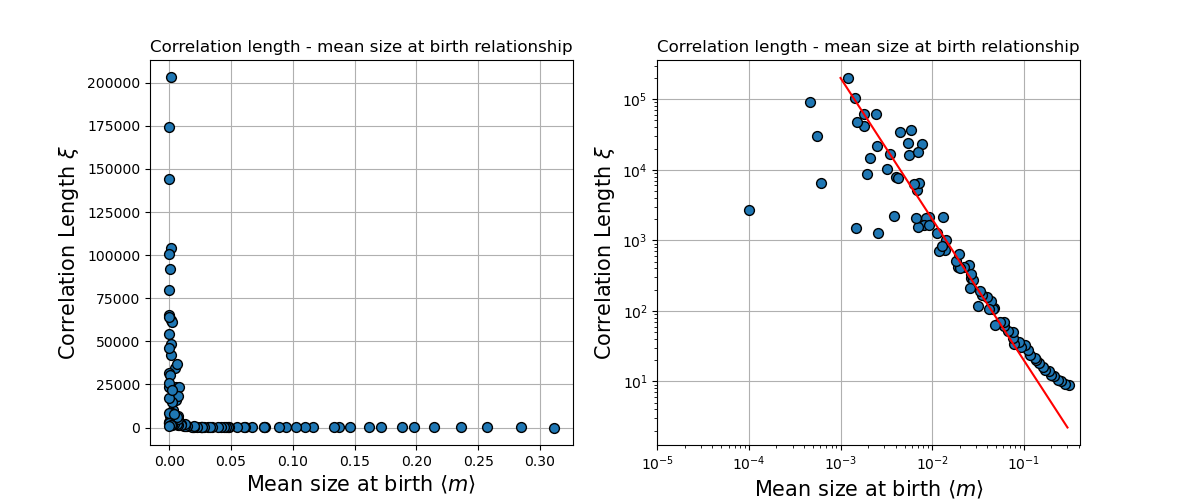

In [57]:
fig, ax_ = plt.subplots(1, 2, figsize = (12, 5))


############################################
# Version of the code dealing with logSizes#
############################################
'''
meanSizesAtBirth = np.mean(np.exp(allSizes), axis = 1)
#meanSizesAtBirthSecondSave = np.mean(np.exp(allSizesSecondSave), axis = 1)
for ax, axis in zip(ax_.flatten(), ['linear', 'log']):
    ax.scatter(meanSizesAtBirth, corrLengths, edgecolor = 'black', s = 50, zorder = 2)
    #ax.scatter(meanSizesAtBirthSecondSave, corrLengthsSecondSave, edgecolor = 'black', s = 50, zorder = 1)
    #ax.set_ylim(bottom = bottom, top = top)
    ax.grid(zorder = 1)
    ax.set_xlabel('Mean size at birth $\\langle m \\rangle$', fontsize = 15)
    ax.set_ylabel('Correlation Length $\\xi$', fontsize = 15)
    ax.set_title('Correlation length - mean size at birth relationship', fontsize = 12)
    ax.set_xscale(axis)
    ax.set_yscale(axis)
    
ax_[1].plot(np.linspace(0.01, 0.3, 1000), powerLaw(np.linspace(0.01, 0.3, 1000), 2.8, -1), color = 'red')
#ax2 = ax_[0].inset_axes([0.3, 0.3, 0.6, 0.6])
#ax2.scatter(meanSizesAtBirth20000, corrLengths20000, edgecolor = 'black', s = 50, zorder = 2)
'''

################################################
# Version of the code not dealing with m       #
################################################

meanSizesAtBirth = np.mean(allSizes, axis = 1)
#meanSizesAtBirthSecondSave = np.mean(np.exp(allSizesSecondSave), axis = 1)
for ax, axis in zip(ax_.flatten(), ['linear', 'log']):
    ax.scatter(meanSizesAtBirth, corrLengths, edgecolor = 'black', s = 50, zorder = 2)
    #ax.scatter(meanSizesAtBirthSecondSave, corrLengthsSecondSave, edgecolor = 'black', s = 50, zorder = 1)
    #ax.set_ylim(bottom = bottom, top = top)
    ax.grid(zorder = 1)
    ax.set_xlabel('Mean size at birth $\\langle m \\rangle$', fontsize = 15)
    ax.set_ylabel('Correlation Length $\\xi$', fontsize = 15)
    ax.set_title('Correlation length - mean size at birth relationship', fontsize = 12)
    ax.set_xscale(axis)
    ax.set_yscale(axis)
    
ax_[1].plot(np.linspace(1e-3, 0.3, 1000), powerLaw(np.linspace(1e-3, 0.3, 1000), .2, -2), color = 'red')
ax_[1].set_xlim(1e-5, np.max(meanSizesAtBirth) + .1)
#ax2 = ax_[0].inset_axes([0.3, 0.3, 0.6, 0.6])
#ax2.scatter(meanSizesAtBirth20000, corrLengths20000, edgecolor = 'black', s = 50, zorder = 2)

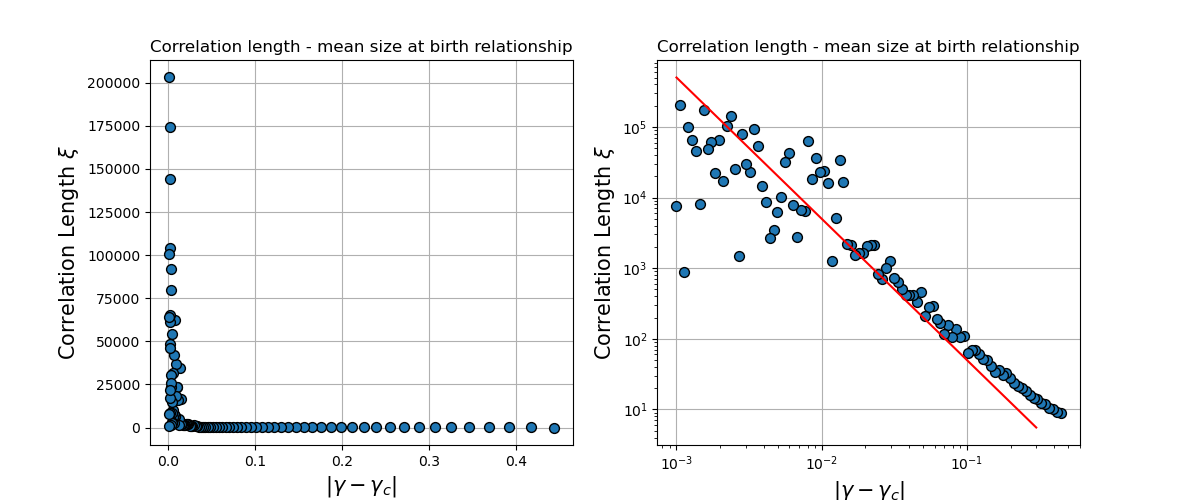

In [21]:
fig, ax_ = plt.subplots(1, 2, figsize = (12, 5))

for ax, axis in zip(ax_.flatten(), ['linear', 'log']):
    ax.scatter(gamma_gammaC, corrLengths, edgecolor = 'black', s = 50, zorder = 2)
    #ax.scatter(gamma_gammaC[45:], corrLengthsSecondSave, edgecolor = 'black', s = 50, zorder = 2)
    #ax.scatter(meanSizesAtBirthSecondSave, corrLengthsSecondSave, edgecolor = 'black', s = 50, zorder = 1)
    #ax.set_ylim(bottom = bottom, top = top)
    ax.grid(zorder = 1)
    ax.set_xlabel('$|\gamma - \gamma_c|$', fontsize = 15)
    ax.set_ylabel('Correlation Length $\\xi$', fontsize = 15)
    ax.set_title('Correlation length - mean size at birth relationship', fontsize = 12)
    ax.set_xscale(axis)
    ax.set_yscale(axis)
    
ax_[1].plot(np.linspace(1e-3, 0.3, 1000), powerLaw(np.linspace(1e-3, 0.3, 1000), .5, -2), color = 'red')
#ax2 = ax_[0].inset_axes([0.3, 0.3, 0.6, 0.6])
#ax2.scatter(meanSizesAtBirth20000, corrLengths20000, edgecolor = 'black', s = 50, zorder = 2)

Text(0.5, 1.0, 'Exponent $\\eta - 2$ approaching the critical point')

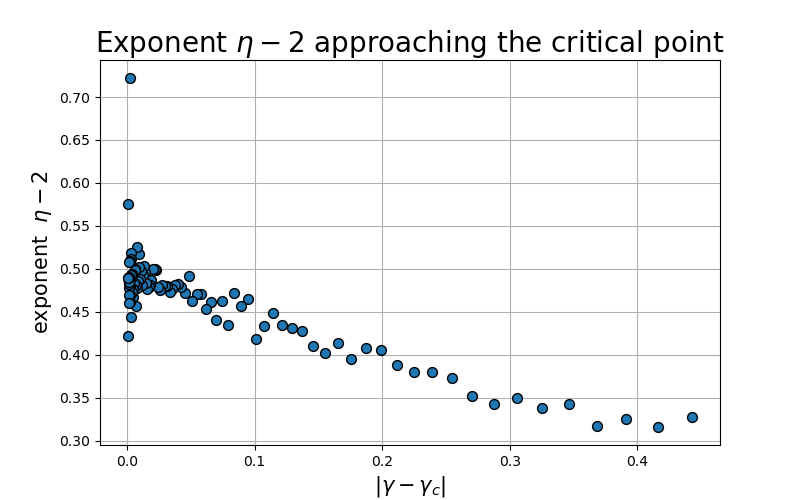

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
ax.scatter(gamma_gammaC, exponentN, edgecolor = 'black', s = 50, zorder = 2)
#ax.scatter(gamma_gammaC[45:], exponentNSecondSave, edgecolor = 'black', s = 50, zorder = 1)
#ax.set_ylim(bottom = bottom,top = top)
ax.grid(zorder = 1)
ax.set_xlabel('$|\\gamma - \\gamma_c|$', fontsize = 15)
ax.set_ylabel('exponent  $\\eta - 2$', fontsize = 15)
ax.set_title('Exponent $\\eta - 2$ approaching the critical point', fontsize = 20)


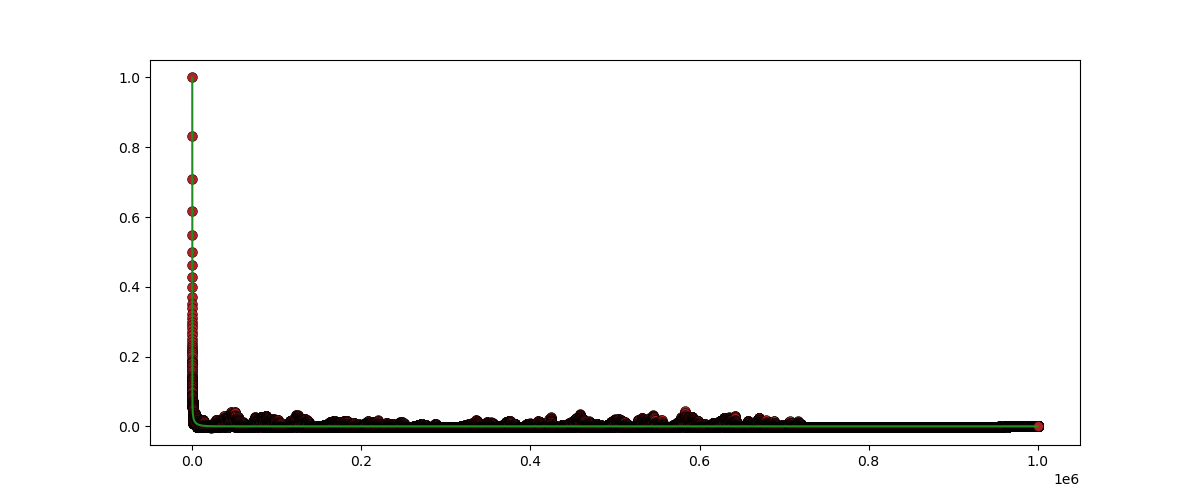

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (12, 5))
autocorrelation = aCorrValues[-1,:]
popt, pcov = curve_fit(autoCorrelationFunc, list(range(1, len(autocorrelation) + 1)), autocorrelation)
ax.scatter(list(range(1, len(autocorrelation) + 1)), autocorrelation, edgecolor = 'black', s = 50, zorder = 2, color = 'firebrick',\
                         linewidth = 0.4)
ax.plot(list(range(1, len(autocorrelation) + 1)), autoCorrelationFunc(np.arange(1, len(autocorrelation) + 1), *popt), color = 'forestgreen')

Text(0, 0.5, 'Normalized $acf$')

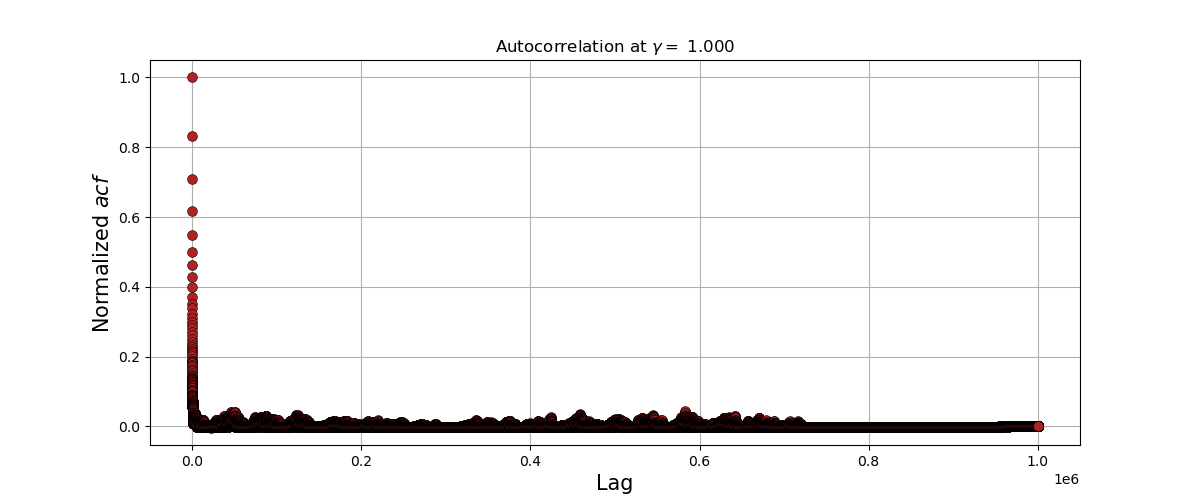

In [57]:
%matplotlib ipympl
fig, ax = plt.subplots(1, 1, figsize = (12, 5))
def fY (x, gamma):
    global title 
    title = f'Autocorrelation at $\\gamma = $ {gamma:.3f}'
    ax.set_title(title)
    idxGamma = list(gammaValues).index(gamma)
    autocorrelation = aCorrValues[idxGamma]
    return autocorrelation

def fY2 (x, gamma):
    idxGamma = list(gammaValues).index(gamma)
    #autocorrelation = aCorrValuesSecondSave[idxGamma]
    popt, pcov = curve_fit(autoCorrelationFunc, list(range(1, len(autocorrelation) + 1)), autocorrelation)
  
    return autoCorrelationFunc(np.array(range(1, len(autocorrelation) + 1)), *popt)


controls = iplt.scatter(range(1, 1000001), fY, gamma = gammaValues, edgecolor = 'black', s = 50, zorder = 2, color = 'firebrick',\
                         linewidth = 0.4)

#_ = iplt.plot(range(1, 1000001), fY2, controls=controls, color = 'forestgreen', linewidth = 2)
ax.grid(zorder = 1)
ax.set_xlabel('Lag', fontsize = 15)
ax.set_ylabel('Normalized $acf$', fontsize = 15)

